# Classiq Challenge Solution

Submitted by team Quantotto

In [1]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
import numpy as np
import math
from matplotlib import pyplot as plt

## Simple Quantum Algorithm

The given differential equation can be solved by applying RY gate. Here we show the simple implementation before moving on to full solution leveraging the algorithm from the scientific paper. We use $(1.0, 1.0)$ as our boundary conditions and evaluate y(t) at $t=\frac{2\cdot\pi}{3}$

In [2]:
t = 2 * np.pi / 3

@qfunc
def main(phi: Output[QBit]):
    allocate(1, phi)
    H(phi)
    RY(2*t, phi)

backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
quantum_model = create_model(main,
    execution_preferences=ExecutionPreferences(
        num_shots=1024, backend_preferences=backend_preferences
    )
)
quantum_program = synthesize(quantum_model)
res = execute(quantum_program)
analytical_res = np.cos(t) + np.sin(t)
amps = np.array([ps.amplitude for ps in res.result()[0].value.parsed_state_vector]) * np.linalg.norm([1.0, 1.0])
quantum_res = complex(res.result()[0].value.state_vector["1"]) * np.linalg.norm([1.0, 1.0])
print(f"Analytical={analytical_res}; Quantum={quantum_res}")

Analytical=0.36602540378443893; Quantum=(0.36602540378443965+0j)


## Full Implementation (by Taylor series expansion)

Now, we will switch to implementing the algorithm as prescribed in the scientific paper titled "[A Quantum Algorithm for Solving Linear Differential Equations: Theory and Experiment](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032307)", presented by Tao Xin, et al. in 2020. 

We define a few helper functions to calculate analytical solution and also some linear algebra auxiliary functionality.

In [3]:
def analytical_solution(boundary_condition, x):
    return boundary_condition[0] * np.cos(x) + boundary_condition[1] * np.sin(x)

def norm(a):
    return np.linalg.norm(a)

def normalize(a):
    return list(np.array(a) / norm(a))

def sqrt_sum(a):
    return np.sqrt(np.sum(np.array(a)))

`create_unitary` will generate a unitary matrix based on the given first column. We apply the Gram-Schmidt orthogonolization to fill out the remaining columns. We will use this function when creating the `Vs1` operator used to encode Taylor expansion coeffiecients. 

In [4]:
def create_unitary(first_column):
    k = len(first_column)
    added_cols = []
    for i in range(k-1):
        row = [0] * k
        row[i] = 1
        added_cols.append(row)
    A = np.array([
        normalize(first_column),
        *added_cols
    ]).T
    n = A.shape[1]
    # Use Gram-Schmidt orthogonalization
    # Credits: https://www.mycompiler.io/view/Di9dsPfR4gy
    for i in range(1, n):
        for j in range(i):
            A[:, i] = A[:, i] - np.dot(A[:, j], A[:, i]) * A[:, j]
            A[:, i] = A[:, i] / norm(A[:, i])
    return A.tolist()

Next we create functions to calculate the Taylor expansion coefficients and V, Vs1 operators. In our case of $y''+y=0$ equation, we do not need Vs2 and our V operator has no effect on the $\ket 0$ state of ancilla (it becomes Z). This is due to the fact that $b=0$ when LDE is re-writtten in Matrix form:

$\frac{d}{dt}y = M \cdot y + b$

See the derivation in the [PDF](./classiq_qsite_2024_open_challenge.pdf), Part II.

In [5]:
def calculate_Cs(t, k):
    arr = [((t) ** i) / math.factorial(i) for i in range(k+1)]
    return arr

def calculate_V():
    return [[1, 0], [0, -1]]

def calculate_Vs1(Cs):
    first_col = normalize(np.sqrt(np.array(Cs)).tolist())
    return create_unitary(first_col)

### Model implementation

Below is our model implementation. There are some helper functions used. In order to not clutter the code of the model, some helper functions are moved to Appendix A.

The algorithm has four main steps:
- Encode qubits (quantum)
- Approximate (quantum)
- Decode (quantum)
- Post-processing (classical)

During post-processing, we post-select the work qubits values for the sub-space of approximator qubits in the $\ket 0$ states.

We split the work of quantum part into three qfuncs:

- `encode` applies Vs1 unitary
- `approximate` prepares the phi qubit in $y_0$ state and repetedly applies the $U_m$ operators

In [6]:

@qfunc
def encode(Vs1: CArray[CArray[CReal]], approximator: QArray):
    unitary(Vs1, approximator)

@qfunc
def approximate(A: CArray[CArray[CReal]], normalized_y0: CArray[CReal], approximator: QNum, phi: QBit):
    inplace_prepare_amplitudes(normalized_y0, bound=0.01, target=phi)
    repeat(2 ** approximator.size, lambda i: control(approximator==i, lambda: power(i, lambda: unitary(A, phi))))


The work is controlled from the `main` function of the model, which uses the `within_apply` to drive the entire implementation.

First we decalre input parameters.

In [7]:
# inputs for y'' + y = 0
y0 = [1.0, 1.0]          # Boundary conditions
A = [[0, 1], [-1, 0]]    # Linear equations (unitary)
k = 7                    # order of approximation
t = np.pi / 3
def total_qubits():
    global k
    return int(np.log2(k+1)) + 1
Cs = calculate_Cs(t, k)
V = calculate_V()
Vs1 = calculate_Vs1(Cs)
normalized_y0 = normalize(y0)

Then, we define `main` entrypoint into the model.

In [8]:
@qfunc
def main(
    phi: Output[QBit],
    approximator: Output[QNum],
    # ancilla: Output[QBit]
):
    allocate(1, phi)
    allocate(int(np.log2(k+1)), approximator)
    # allocate(1, ancilla)
    within_apply(
        within=lambda: encode(Vs1, approximator),
        apply=lambda: approximate(A, normalized_y0, approximator, phi)
    )

We check that the model can be successfully created and synthesized:

In [9]:
qmod = create_model(main)
qprog = synthesize(qmod)
# show(qprog)

Now we handle the post-processing, selecting the appropriate states with approximator qubits being 0 and extract the solution. All that is encapsulated in the `solve` function, which returns a tuple of position and velocity represented by $y(t)$ and $y'(t)$ respectively in the solution vector.

In [10]:
def state_vector_keys(qubits: int) -> tuple[str, str]:
    return "0" * qubits, "0" * (qubits-1) + "1"

backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)

def solve(t) -> tuple[float, float]:
    # solve differential equation using quantum algorithn
    # and return a tuple of position and velocity at time t

    # Calculate model parameters
    global Cs, V, Vs1, normalized_y0
    Cs = calculate_Cs(t, k)
    V = calculate_V()
    Vs1 = calculate_Vs1(Cs)
    normalized_y0 = normalize(y0)

    # Create, synthesize and execute the model
    quantum_model = create_model(main,
        execution_preferences=ExecutionPreferences(
            num_shots=1024, backend_preferences=backend_preferences
        )
    )
    quantum_program = synthesize(quantum_model)
    res = execute(quantum_program)

    # post-select results with ancilla and approximator qubits equal to 0
    amps = [
        ps.amplitude for ps in res.result()[0].value.parsed_state_vector
        if ps["approximator"] == 0
    ]
    # Re-scale amplitudes
    total_prob = (amps[0] * amps[0].conjugate() + amps[1] * amps[1].conjugate())
    
    # Extract position and velocity (position is the y(t) and velocity y'(t))
    # Position is amplitude of phi=0 and velocity is amplitude of phi=1
    Y_key, V_key = state_vector_keys(total_qubits())
    Y_amp = complex(res.result()[0].value.state_vector[Y_key]) / np.sqrt(total_prob)
    V_amp = complex(res.result()[0].value.state_vector[V_key]) / np.sqrt(total_prob)

    # Calculate real values and rescale the values by norm of y0
    Yt = np.sqrt((Y_amp * Y_amp.conjugate()).real) * norm(y0)
    Vt = np.sqrt((V_amp * V_amp.conjugate()).real) * norm(y0)
    return (Yt, Vt)

### Accuracy Study

We can now study the accuracy of our model for various orders of approximation. We will vary the order of approximation and calculate both quantum and analytical solutions,

We will use $k = 1, 3, 7$ as three orders of approximation and plot quantum and classical solutions alongside each other to demonstrate that accuracy increases with higer orders of approximation.

The below code will solve the differential equation on the $(0, \pi)$ interval.

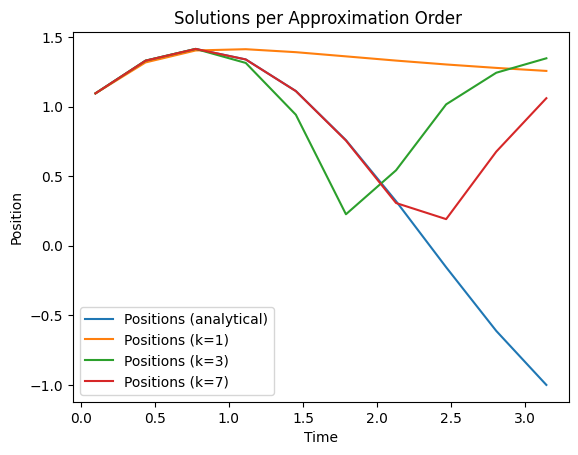

In [11]:

t_axis = np.linspace(0.1, np.pi, 10)
analytical_positions = [analytical_solution(y0, t) for t in t_axis]
fig, ax = plt.subplots()
ax.plot(t_axis, analytical_positions, label="Positions (analytical)")

approximation_orders = (1, 3, 7)
for approx_order in approximation_orders:
    k = approx_order
    positions = [solve(t)[0] for t in t_axis]
    ax.plot(t_axis, positions, label=f"Positions (k={k})")

ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.legend()

ax.set_title(f"Solutions per Approximation Order ")
plt.show()


# Calculating Energies

Using the `solve` function it is trivial to calculate the kinetic and potentail energies.

Potential energy: $U = \frac{k \cdot x^2}{2} = \frac{x^2}{2} = \frac{{y(t)}^2}{2}$

Kinetic energy: $K = \frac{m \cdot v^2}{2} = \frac{v^2}{2} = \frac{{y'(t)}^2}{2}$

In [12]:
def calculate_energies(t) -> tuple[float, float]:
    # Calculate kinetic and potential energy at time t

    Yt, Vt = solve(t)
    return (Vt ** 2) / 2, (Yt ** 2) / 2

Now, we can evaluate the energies on the $(0, 1)$ interval. We set the order of approximation $k=3$. As we saw it produces very accurate results on the interval we are interested in. We run the solution for a few different boundary conditions and plot the results. They agree with classical solution for harmonic oscillator.

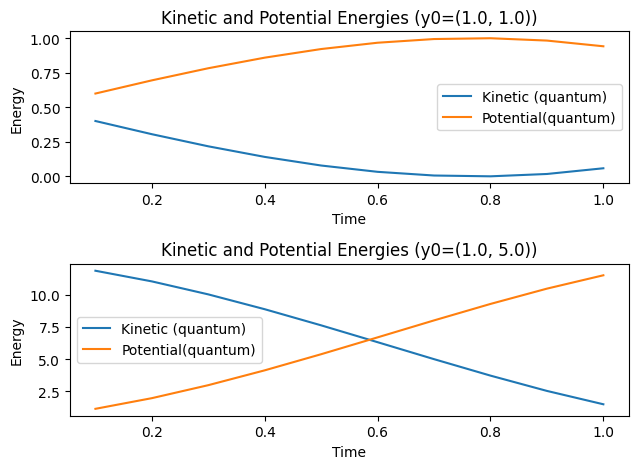

In [13]:
k = 3
t_axis = np.linspace(0.1, 1.0, 10)
boundaries = [(1.0, 1.0), (1.0, 5.0)]
fig, axes = plt.subplots(len(boundaries))
for i, b in enumerate(boundaries):
    y0 = b
    ks, ps = [], []
    for t in t_axis:
        kinetic, potential = calculate_energies(t)
        ks.append(kinetic)
        ps.append(potential)
    axes[i].plot(t_axis, ks, label="Kinetic (quantum)")
    axes[i].plot(t_axis, ps, label="Potential(quantum)")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Energy")
    axes[i].legend()
    axes[i].set_title(f"Kinetic and Potential Energies (y0={y0})")
fig.tight_layout()
plt.show()


## Model Optimization

We will select the $k=3$ as our order of approximation. We used it to generate all of the above results. Boundary condition will be $(1.0, 1.0)$. With that, we generate the model using the default settings and evaluate the width and depth.

Then, we will apply optimizations and observe the results.

Note that in the course of adapting the algorithm for our case of a concrete differential equation $y'' + y = 0$, we already applied a few optimizations:
- Removes the ancilla qubit, because we don't need to create a super-position of $y_0$ and $b$ due to $b=0$
- Removed operators V and Vs2
- Applying Ux and Vs1 without the controls
- Selected intermediate order of optimization ($k=3$) further reducing the number of required approximator qubits

Let's see if we can squeeze any other optimizations using the Classiq toolkit.

In [14]:
def generate_model(approximation_order, max_depth=None):
    global k, y0, Cs, Vs1, normalized_y0
    k = approximation_order
    y0 = [1.0, 1.0]
    Cs = calculate_Cs(t, k)
    Vs1 = calculate_Vs1(Cs)
    normalized_y0 = normalize(y0)

    # Create, synthesize and execute the model
    quantum_model = create_model(main)
    if max_depth is not None:
        quantum_model_with_constraints = set_constraints(
            quantum_model, Constraints(optimization_parameter=OptimizationParameter.WIDTH, max_depth=max_depth)
        )
        quantum_program = synthesize(quantum_model_with_constraints)
    else:
        quantum_program = synthesize(quantum_model)
    width = QuantumProgram.from_qprog(quantum_program).data.width
    depth = QuantumProgram.from_qprog(quantum_program).transpiled_circuit.depth
    return quantum_model, width, depth


In [15]:
_, width, depth = generate_model(3)
print(f"Circuit with default parameters and k=3\n    width={width}\n    depth={depth}")
_, width, depth = generate_model(7)
print(f"Circuit with default parameters and k=7\n    width={width}\n    depth={depth}")

Circuit with default parameters and k=3
    width=3
    depth=83
Circuit with default parameters and k=7
    width=4
    depth=413


The circuit is not very deep with all the optimizations already in place.

In [16]:
try:
    _, width, depth = generate_model(7, max_depth=256)
except Exception as e:
    print(str(e))
else:
    print(f"Circuit with default parameters and k=7\n    width={width}\n    depth={depth}")

Could not find a solution that satisfies the constraints: Couldn't generate a circuit with satisfactory depth.
Minimal value found: 442

Error identifier: E668FDB44-50D0-450D-8FA2-64F0400D3171.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack


If we try to reduce the depth, we are getting an error message that indicates we cannot optimize any further. Our final model that we feel comfortable with optimization wise is using order of approximation $k=3$. This is what we will commit as our solution.

In [17]:
model, _, _ = generate_model(3)
write_qmod(model, "diff_eq")
qprog = synthesize(model)
with open("diff_eq.qprog", "w") as f:
    f.write(qprog)